# Load Runtime Service

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

## Map the problem

In [13]:
from qiskit import QuantumCircuit

def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """Creates a circuit with n-qubit GHZ state

        Args:
            n (int): Number of qubits in the n-qubit GHZ state

        Returns:
            QuantumCircuit: A circuit that generates n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")

    return qc

n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

In [8]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range(n-1)]
# print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

99


## Optimize the problem for execution on quantum hardware

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# defined in the first cell 
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

In [15]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

In [16]:
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

cswb3je7ynng008ysaw0


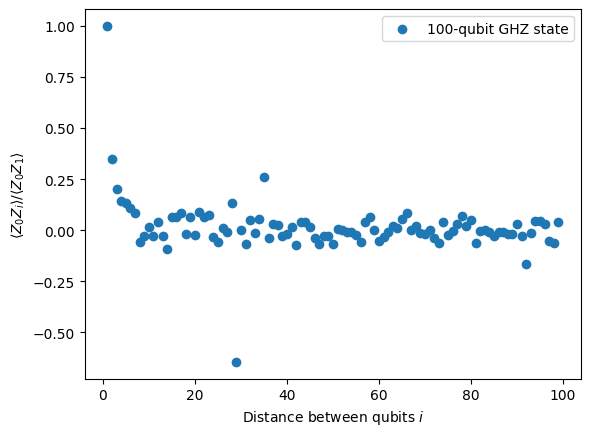

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle $')
plt.legend()
plt.show()